In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(CellChat))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(uwot))
suppressPackageStartupMessages(library(anndata))
reticulate::py_require(packages = 'umap-learn')
reticulate::py_require(c("pandas", "anndata"))
options(stringsAsFactors = FALSE)
options(future.globals.maxSize = 20 * 1024^3)  

In [2]:
cellchat.N <- readRDS("../Data/Cellchat/cellchat_FLC_Normal.rds")
cellchat.P <- readRDS(paste('../Data/Cellchat/cellchat_FLC_Primary.rds',sep=''))
cellchat.N <- netAnalysis_computeCentrality(cellchat.N, slot.name = "netP") 
cellchat.P <- netAnalysis_computeCentrality(cellchat.P, slot.name = "netP")

In [3]:
object.list <- list(N = cellchat.N, P = cellchat.P)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))

new_order <- c('Cholangiocyte','Hepatocyte','Tumor','Endothelial','Vascular mural','HSC','myCAF','Macrophage','DC','Mast cell','T cell','Treg','NK cell','B cell')
colors<-c('#fdb462','#fb8072','#80b1d3','#bc80bd','#fccde5','#cedb9c','#d6616b','#DAA520','#843c39','#0000FF','#1E90FF','#FF7F50','#FFC0CB','#FF0000')
celltype.use <- setNames(colors,new_order)

all_pathways <- c(
  "ANGPT", "ANNEXIN", "BTLA", "IGF", "SLIT", "CHEMERIN", "BRADYKININ","PDGF", "BMP", "PROS", "GAS", "CCL", "IL1", "TGFb", "VEGF",
  "COMPLEMENT", "HGF", "LIGHT", "GALECTIN", "GRN", "ANGPTL", "NRG","IL16", "CSF", "LIFR", "AGT", "SEMA3", "CALCR", "KIT", "CXCL",
  "FGF", "VISFATIN", "EGF", "GDF", "WNT", "PARs", "ACTIVIN", "NT",'ncWNT','PTPR')
highlight_pathways <- c( "CXCL")

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



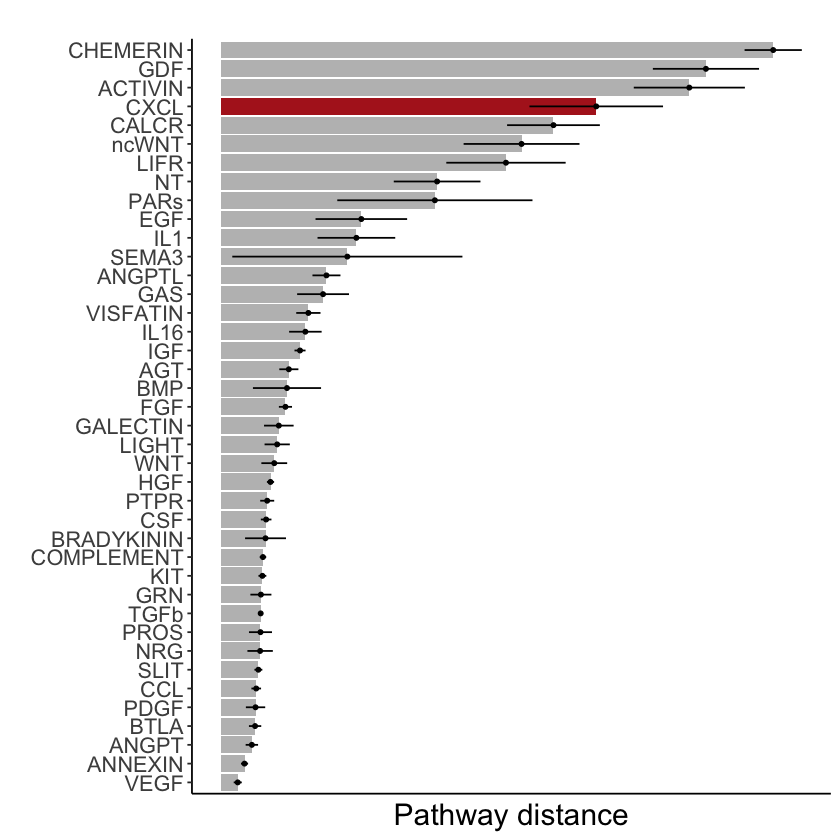

In [4]:
all_similarity_df <- data.frame()
for (i in 1:20) {
  set.seed(1234 + i)
  reticulate::py_run_string(sprintf("
import random
import numpy as np
random.seed(%d)
np.random.seed(%d)
", 1234 + i, 1234 + i))

  invisible(capture.output({
    cellchat <- computeNetSimilarityPairwise(cellchat, type = "functional")
    cellchat <- netEmbedding(cellchat, type = "functional")
    cellchat <- netClustering(cellchat, type = "functional")    
  similarity_df <- rankSimilarity(cellchat, type = "functional")
  similarity_df <- similarity_df$data
  similarity_df$run <- i
  all_similarity_df <- rbind(all_similarity_df, similarity_df)
    }))
}

summary_df <- all_similarity_df %>%
  group_by(name) %>%
  summarise(
    mean_dist = mean(dist, na.rm = TRUE),
    sd_dist = sd(dist, na.rm = TRUE),
    .groups = "drop"
  )

annotated_df <- data.frame(
  pathway = all_pathways,
  immune_status = ifelse(all_pathways %in% highlight_pathways, "CXCL", "Other")
)

plot_df <- summary_df %>%
  left_join(annotated_df, by = c("name" = "pathway"))

gg1<-ggplot(plot_df, aes(x = reorder(name, mean_dist), y = mean_dist, fill = immune_status)) +
  geom_bar(stat = "identity") +
  geom_errorbar(aes(ymin = mean_dist - sd_dist, ymax = mean_dist + sd_dist),
                width = 0) +
geom_point(color = "black", size = 1) + 
  theme_classic() +
coord_flip() +
theme(axis.ticks.x = element_blank(),legend.position = "none",axis.text.x = element_blank(),
     axis.title.x = element_text(size = 18),axis.text.y = element_text(size = 13),
     panel.background = element_rect(fill = "transparent", color = NA),
  plot.background = element_rect(fill = "transparent", color = NA))+
  scale_fill_manual(values = c("CXCL" = "firebrick", "Other" = "grey")) +
  labs(x = "", y = "Pathway distance", fill = "",title = "") 

print(gg1)

Do heatmap based on a merged object 




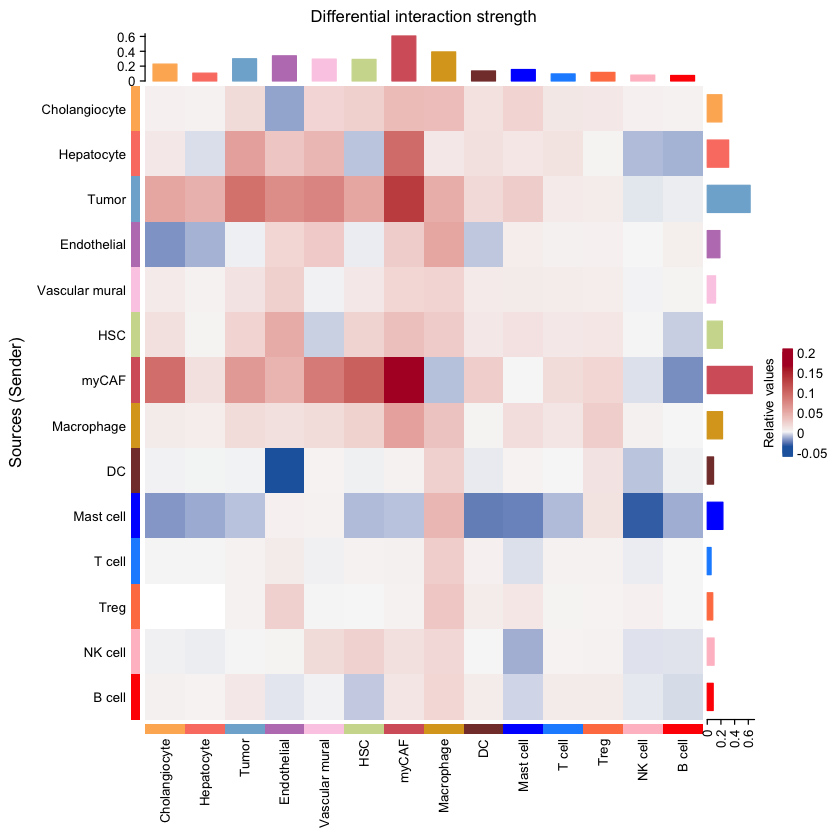

In [5]:
netVisual_heatmap(cellchat, measure = "weight", color.use = celltype.use)

[1] "Normal CXCL12_CXCR4"


[[1]]


[1] "Primary CXCL12_CXCR4"


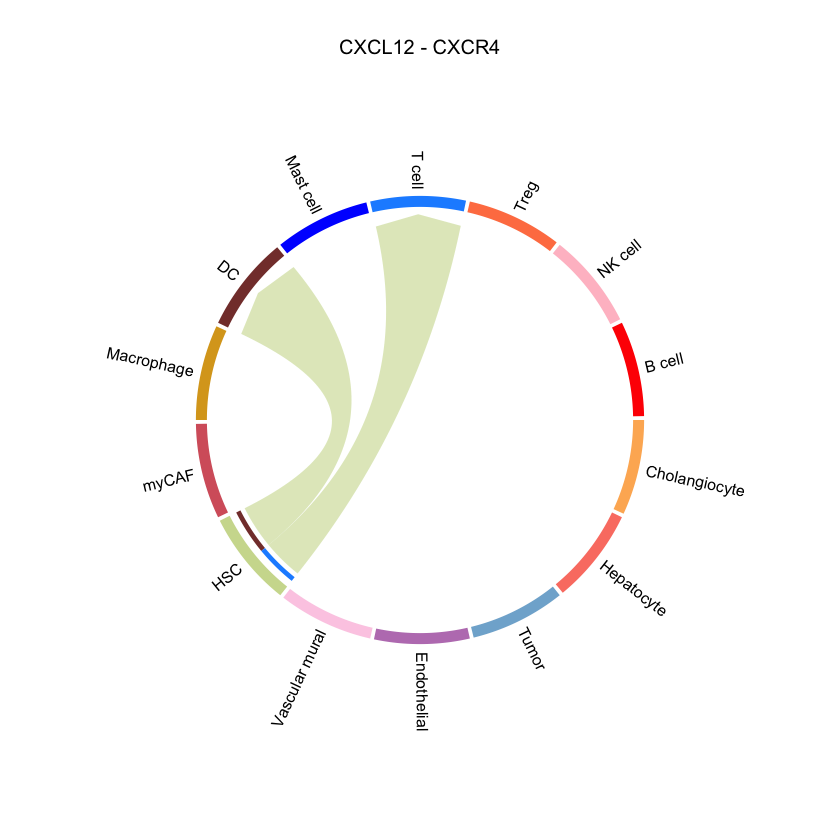

[[1]]


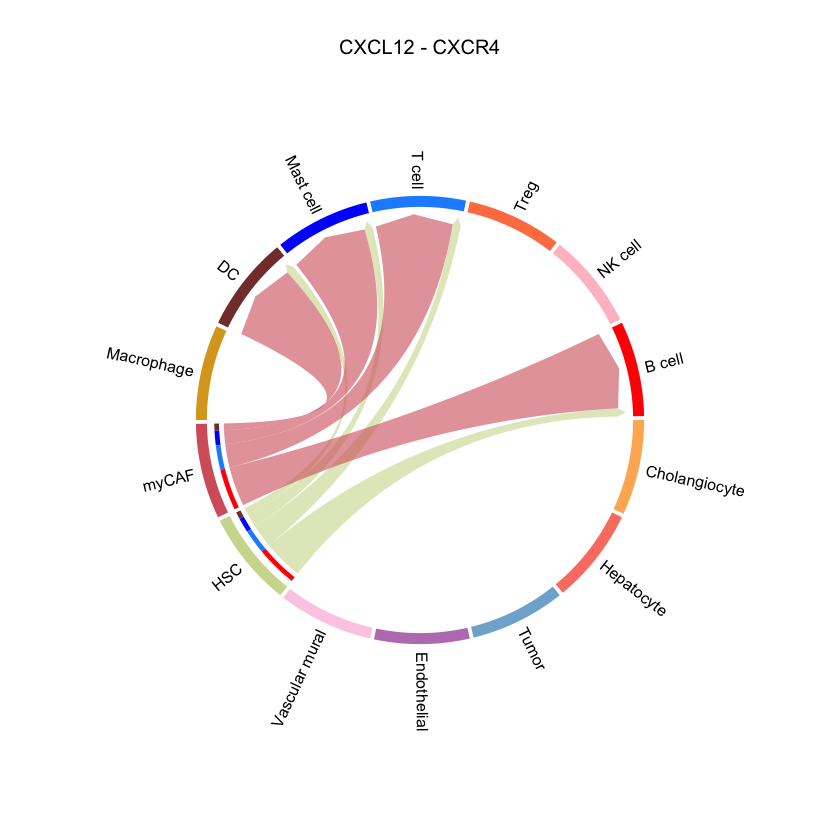

In [6]:
pathways.show <- c("CXCL") 
pairLR.CXCL <- extractEnrichedLR(cellchat.P, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[1,]

print(paste('Normal',LR.show))
netVisual_individual(cellchat.N, signaling = pathways.show,  pairLR.use = LR.show, color.use=celltype.use,layout='chord')

print(paste('Primary',LR.show))
netVisual_individual(cellchat.P, signaling = pathways.show,  pairLR.use = LR.show, color.use=celltype.use,layout='chord')